In [531]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas
pandas.set_option('display.max_rows', 1000)
pandas.set_option('display.max_columns', 1000)

%reload_ext autoreload
%autoreload 2

In [533]:
import re
import numpy
import pandas
from sklearn.preprocessing import StandardScaler

def first_dataset():
    
    train = pandas.read_csv('input/train.csv')
    test = pandas.read_csv('input/test.csv')
    
    datasets = [train, test]
    
    def get_title(name):
        if re.search(' ([A-Za-z]+)\.', name):
            return re.search(' ([A-Za-z]+)\.', name).group(1)
        return ""

    
    for dataset in datasets:

        dataset['Cabin'] = dataset['Cabin'].apply(lambda x: 1 if type(x) == str else 0)
        
        dataset['Age'] = dataset['Age'].fillna(-1).astype(int)
        
        dataset['Fare'] = dataset['Fare'].fillna(-1).astype(int)

        dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
        
        dataset['Title'] = dataset['Name'].apply(get_title)
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(-1)

        dataset['Embarked'] = dataset['Embarked'].fillna('S')
        dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
        dataset.drop(['PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
        
    X_train = train.drop(['Survived'], axis=1)
    y_train = train['Survived']
    X_test = test
    
    std = StandardScaler()
    std.fit(X_train)
    X_train = std.transform(X_train).astype(numpy.float32)
    X_test = std.transform(X_test).astype(numpy.float32)

    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train}

In [534]:
df = first_dataset()

In [1]:
# LightGBM Single モデル

In [535]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split

In [536]:
X_train, X_valid, y_train, y_valid = train_test_split(df['X_train'], df['y_train'], test_size=0.2, random_state=0)

In [537]:
train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_dataset = lgbm.Dataset(data=X_valid, label=y_valid, free_raw_data=False)
final_train_dataset = lgbm.Dataset(data=df['X_train'], label=df['y_train'], free_raw_data=False)

In [538]:
lgbm_params = {
    'boosting': 'dart', 
    'application': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 41,
    'metric': 'binary_logloss',
    'drop_rate': 0.15
}

In [539]:
evaluation_results = {}
clf = lgbm.train(train_set=train_dataset,
                 params=lgbm_params,
                 valid_sets=[train_dataset, test_dataset], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	Train's binary_logloss: 0.464484	Test's binary_logloss: 0.487243
[40]	Train's binary_logloss: 0.408891	Test's binary_logloss: 0.446751
[60]	Train's binary_logloss: 0.393729	Test's binary_logloss: 0.442872
[80]	Train's binary_logloss: 0.378047	Test's binary_logloss: 0.436778
[100]	Train's binary_logloss: 0.37472	Test's binary_logloss: 0.436104
[120]	Train's binary_logloss: 0.365463	Test's binary_logloss: 0.432786
[140]	Train's binary_logloss: 0.35433	Test's binary_logloss: 0.424344
[160]	Train's binary_logloss: 0.35888	Test's binary_logloss: 0.426459
[180]	Train's binary_logloss: 0.337339	Test's binary_logloss: 0.416787
[200]	Train's binary_logloss: 0.324049	Test's binary_logloss: 0.413225
[220]	Train's binary_logloss: 0.317539	Test's binary_logloss: 0.415004
[240]	Train's binary_logloss: 0.308851	Test's binary_logloss: 0.415523
[260]	Train's binary_logloss: 0.302299	Test's binary_logloss: 0.416495
[280]	Train's binary_logloss: 0.2962	Test's binary_logloss: 0.41336
[300]	Train's bi

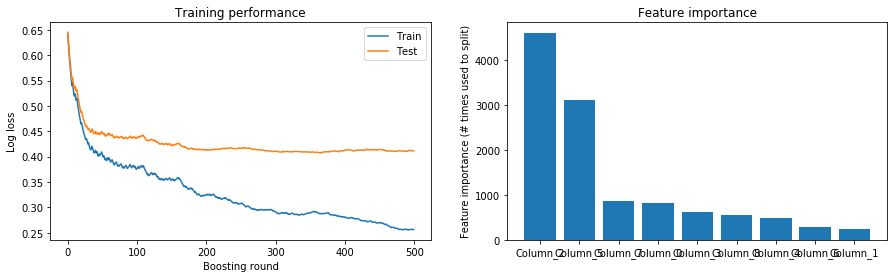

In [540]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=[15, 4])

axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train');
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test');
axs[0].set_ylabel('Log loss');
axs[0].set_xlabel('Boosting round');
axs[0].set_title('Training performance');
axs[0].legend();

importances = pandas.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False);
axs[1].bar(x=numpy.arange(len(importances)), height=importances['importance']);
axs[1].set_xticks(numpy.arange(len(importances)));
axs[1].set_xticklabels(importances['features']);
axs[1].set_ylabel('Feature importance (# times used to split)');
axs[1].set_title('Feature importance');

In [541]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

preds = numpy.round(clf.predict(X_valid))
print(f'Accuracy score = \t {accuracy_score(y_valid, preds)}')
print(f'Precision score = \t {precision_score(y_valid, preds)}')
print(f'Recall score =   \t {recall_score(y_valid, preds)}')
print(f'F1 score =      \t {f1_score(y_valid, preds)}')

Accuracy score = 	 0.8603351955307262
Precision score = 	 0.8793103448275862
Recall score =   	 0.7391304347826086
F1 score =      	 0.8031496062992126


In [542]:
clf_final = lgbm.train(train_set=final_train_dataset,
                      params=lgbm_params,
                      num_boost_round=500,
                      verbose_eval=0
                      )

y_pred = numpy.round(clf_final.predict(df['X_test'])).astype(int)

In [543]:
passengerId = pandas.read_csv('test.csv')['PassengerId']
dataframe = pandas.DataFrame({'PassengerId': passengerId, 'Survived': y_pred})

In [544]:
dataframe.to_csv('submission/single_lgbm_model.csv', index=False)

# heamy

In [545]:
#!pip install rgf_python
#!pip install keras
#!pip install tensorflow

In [546]:
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

In [547]:
from rgf.sklearn import RGFClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [548]:
ds = Dataset(preprocessor=first_dataset, use_cache=False)

In [549]:
et_params = {'n_estimators': 100, 'max_features': 0.5, 'max_depth': 18, 'min_samples_leaf': 4, 'n_jobs': -1}
rf_params = {'n_estimators': 125, 'max_features': 0.2, 'max_depth': 25, 'min_samples_leaf': 4, 'n_jobs': -1}
rgf_params = {'algorithm': 'RGF_Sib', 'loss': 'Log'}

In [550]:
from keras.layers import Dense
from keras.models import Sequential

def NuralNetClassifier(X_train, y_train, X_test, y_test=None):
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=0)
    y_pred = numpy.ravel(model.predict(X_test))
    
    return y_pred

In [551]:
def LightGBMClassifier(X_train, y_train, X_test, y_test=None):
    lgbm_params = {
        'boosting': 'dart', 
        'application': 'binary',
        'learning_rate': 0.05,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'num_leaves': 41,
        'metric': 'binary_logloss',
        'drop_rate': 0.15
    }
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
    test_dataset = lgbm.Dataset(data=X_valid, label=y_valid, free_raw_data=False)
    final_train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
    evaluation_results = {}
    clf = lgbm.train(train_set=train_dataset,
                     params=lgbm_params,
                     valid_sets=[train_dataset, test_dataset], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluation_results,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=0
                    )
    
    clf_final = lgbm.train(train_set=final_train_dataset,
                          params=lgbm_params,
                          num_boost_round=500,
                          verbose_eval=0
                          )

    y_pred = clf_final.predict(X_test)

    return y_pred

In [552]:
pipeline = ModelsPipeline(
    Classifier(estimator=LightGBMClassifier, dataset=ds, use_cache=False),
    Classifier(estimator=NuralNetClassifier, dataset=ds, use_cache=False),
    Classifier(estimator=RGFClassifier, dataset=ds, use_cache=False, parameters=rgf_params),
    Classifier(estimator=ExtraTreesClassifier, dataset=ds, use_cache=False, parameters=et_params),
    Classifier(estimator=RandomForestClassifier, dataset=ds, use_cache=False, parameters=rf_params),
    Classifier(estimator=LogisticRegression, dataset=ds, use_cache=False),
    Classifier(estimator=KNeighborsClassifier, dataset=ds, use_cache=False)
)

In [559]:
#pipeline = ModelsPipeline(
    #Classifier(estimator=LightGBMClassifier, dataset=ds, use_cache=False),
    #Classifier(estimator=NuralNetClassifier, dataset=ds, use_cache=False),
    #Classifier(estimator=RGFClassifier, dataset=ds, use_cache=False, parameters=rgf_params),
    #Classifier(estimator=ExtraTreesClassifier, dataset=ds, use_cache=False, parameters=et_params),
    #Classifier(estimator=RandomForestClassifier, dataset=ds, use_cache=False, parameters=rf_params),
    #Classifier(estimator=LogisticRegression, dataset=ds, use_cache=False),
    #Classifier(estimator=KNeighborsClassifier, dataset=ds, use_cache=False)
#)

In [553]:
stack_ds = pipeline.stack(k=10, seed=0, add_diff=False, full_test=True)

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


# heamy single stacking

In [522]:
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, use_cache=False)

In [523]:
y_trues, y_preds = stacker.validate(k=3)

In [524]:
y_pred = stacker.predict()

In [525]:
dataframe = pandas.DataFrame({'PassengerId': pandas.read_csv('input/test.csv')['PassengerId'], 'Survived': numpy.round(y_pred).astype(int)})

dataframe.head(10)

dataframe.to_csv('submission/heamy_single_stacking_model.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


# heamy multiple stacking

In [526]:
from sklearn.metrics import log_loss

In [558]:
#pipeline2 = ModelsPipeline(
#    Classifier(estimator=LightGBMClassifier, dataset=stack_ds, use_cache=False),
#    Classifier(estimator=LogisticRegression, dataset=stack_ds, use_cache=False)
#    #Classifier(estimator=NuralNetClassifier, dataset=stack_ds, use_cache=False)
#)

In [527]:
pipeline2 = ModelsPipeline(
    Classifier(estimator=LightGBMClassifier, dataset=stack_ds, use_cache=False),
    #Classifier(estimator=LogisticRegression, dataset=stack_ds, use_cache=False)
    Classifier(estimator=NuralNetClassifier, dataset=stack_ds, use_cache=False)
)

In [528]:
weights = pipeline2.find_weights(log_loss)
predictions = pipeline2.weight(weights).execute()

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


Best Score (log_loss): 0.3849248890947457
Best Weights: [0.50000511 0.49999489]


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


In [556]:
#dataframe = pandas.read_csv('each_model_prediction.csv')

In [557]:
#round_binary = lambda x: numpy.round(x).astype(int)
#
#dataframe.rename(columns={
#    'LightGBMClassifier(b1759c5d030ac4ad5e9c9d02dc6e6851)': 'lgb',
#    'NuralNetClassifier(4a02424325deb2217315ba47aec9f02d)': 'nn',
#    'RGFClassifier(1b94dd02b592fd853c50cc5031846802)': 'rgf',
#    'ExtraTreesClassifier(6653206da804c138e0348e61712fbd18)': 'et',
#    'RandomForestClassifier(0d36563123af8761ca6ec7ef2527dae9)': 'rf',
#    'LogisticRegression(81205c7ce49ef3d79e25ecf831b1a6ca)': 'lr',
#    'KNeighborsClassifier(f6951d8b5e8e63e97d77bccf18cc41bc)': 'knn'
#}).applymap(round_binary)

In [529]:
dataframe = pandas.DataFrame({'PassengerId': pandas.read_csv('input/test.csv')['PassengerId'], 'Survived': numpy.round(predictions).astype(int)})
dataframe.to_csv('submission/heamy_multiple_stacking_model.csv', index=False)

In [530]:
dataframe.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


# sklearn single stacking

In [498]:
from sklearn.ensemble import StackingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [499]:
lgbm_params = {
        'boosting': 'dart', 
        'application': 'binary',
        'learning_rate': 0.05,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'num_leaves': 41,
        'metric': 'binary_logloss',
        'drop_rate': 0.15
}
keras_params = {'epochs': 10, 'batch_size': 10}

In [555]:
#def build_fn():
#    clf = Sequential()
#    clf.add(Dense(12, input_dim=9, activation='relu'))
#    clf.add(Dense(6, activation='relu'))
#    clf.add(Dense(1, activation='sigmoid'))
#    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return clf

In [500]:
estimators = [
    ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
    #('nn', KerasClassifier(build_fn=build_fn, **keras_params)),
    ('rgf', RGFClassifier(**rgf_params)),
    ('et', ExtraTreesClassifier(**et_params)),
    ('rf', RandomForestClassifier(**rf_params)),
    ('lr', LogisticRegression()),
    ('knn', KNeighborsClassifier())
]

In [554]:
#python3.7/dist-packages/sklearn/ensemble/_base.py in _validate_estimators(self)
#    249                 raise ValueError(
#    250                     "The estimator {} should be a {}.".format(
#--> 251                         est.__class__.__name__, is_estimator_type.__name__[3:]
#    252                     )
#    253                 )
#
#ValueError: The estimator NuralNetworkClassifier should be a classifier.

In [502]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [503]:
clf.fit(df['X_train'], df['y_train'])

StackingClassifier(cv=None,
                   estimators=[('lgb',
                                LGBMClassifier(application='binary',
                                               boosting='dart',
                                               boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               drop_rate=0.15,
                                               feature_fraction=0.7,
                                               importance_type='split',
                                               learning_rate=0.05, max_depth=-1,
                                               metric='binary_logloss',
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_data_in_leaf=20,
                               

In [504]:
predictions = clf.predict(df['X_test'])

In [505]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [506]:
dataframe = pandas.DataFrame({'PassengerId': pandas.read_csv('input/test.csv')['PassengerId'], 'Survived': numpy.round(predictions).astype(int)})
dataframe.to_csv('submission/sklearn_single_stacking_model.csv', index=False)

# sklearn multiple stacking

In [507]:
final_estimator = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        ('lr', LogisticRegression())
    ],
    final_estimator=LogisticRegression()
)

In [508]:
clf = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        #('nn', KerasClassifier(build_fn=build_fn, **keras_params)),
        ('rgf', RGFClassifier(**rgf_params)),
        ('et', ExtraTreesClassifier(**et_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier())
    ],
    final_estimator=final_estimator
)

In [509]:
clf.fit(df['X_train'], df['y_train'])

StackingClassifier(cv=None,
                   estimators=[('lgb',
                                LGBMClassifier(application='binary',
                                               boosting='dart',
                                               boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               drop_rate=0.15,
                                               feature_fraction=0.7,
                                               importance_type='split',
                                               learning_rate=0.05, max_depth=-1,
                                               metric='binary_logloss',
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_data_in_leaf=20,
                               

In [510]:
predictions = clf.predict(df['X_test'])

In [511]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [512]:
dataframe = pandas.DataFrame({'PassengerId': pandas.read_csv('input/test.csv')['PassengerId'], 'Survived': numpy.round(predictions).astype(int)})
dataframe.to_csv('submission/sklearn_multiple_stacking_model.csv', index=False)